# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [45]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, color

from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize
from mrcnn.model import log

%matplotlib inline 

debug = 0
# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to COCO trained weights
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Path to signs trained weights
SIGNS_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_signs.h5")

#DataSet PATH
DATASET_PATH = os.path.join(ROOT_DIR,"signsDataset")


'''
# Tensorflow
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config, ...)

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adamfrom keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)sess = tf.Session(config=config)set_session(sess)  # set this TensorFlow session as the default session for Keras

'''

C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN


'\n# Tensorflow\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.allow_growth = True\nsession = tf.Session(config=config, ...)\n\nfrom keras.callbacks import ModelCheckpoint\nfrom keras.models import Model, load_model, save_model, Sequential\nfrom keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D\nfrom keras.layers import GRU, Bidirectional, BatchNormalization, Reshape\nfrom keras.optimizers import Adamfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU\nconfig.log_device_placement = True  # to log device placement (on which device the operation ran)sess = tf.Session(config=config)set_session(sess)  # set this TensorFlow session as the default session for Keras\n\n'

In [46]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
'''
import kerasconfig = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
'''
#Create list with bbox info
import csv
columnNames = []
maskValues = []

listOfLabels = []

with open(DATASET_PATH+"\\allAnnotations.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    numOfCol=7

    for row in csv_reader:
        if line_count == 0:
            columnNames = row[0].split(';')
            if(debug):print(columnNames)
            line_count += 1
        else:
            maskValues.append(row[0].split(';'))
            line_count += 1
    print(f'Processed {line_count} lines.')

for maskValuesRow in maskValues:
    maskValuesRow[0]=maskValuesRow[0].split('/')[2]
    
    
for maskValuesRow in maskValues:
    if(maskValuesRow[1] not in listOfLabels):
        listOfLabels.append(maskValuesRow[1])
    if(maskValuesRow[0] == "keepRight_1323823831.avi_image9.png"):
        print(maskValuesRow[0])
    
print(listOfLabels)
print(len(listOfLabels))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7954469564588945558
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6600035533
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11240211120942363762
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Processed 7856 lines.
keepRight_1323823831.avi_image9.png
['stop', 'speedLimitUrdbl', 'speedLimit25', 'pedestrianCrossing', 'speedLimit35', 'turnLeft', 'slow', 'speedLimit15', 'speedLimit45', 'rightLaneMustTurn', 'signalAhead', 'keepRight', 'laneEnds', 'school', 'merge', 'addedLane', 'rampSpeedAdvisory40', 'rampSpeedAdvisory45', 'curveRight', 'speedLimit65', 'truckSpeedLimit55', 'thruMergeLeft', 'speedLimit30', 'stopAhead', 'yield', 'thruMergeRight', 'dip', 'schoolSpeedLimit25', 'thruTrafficMergeLeft', 'noRightTurn', 'rampSpeedAdvisory35', 'curveLeft', 'rampSpeedAdvisory20', 'noLeftTurn', 'zoneAhead25', 'zoneAhead45', 'doNotEnte

## Configurations

In [47]:
class SignsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "signs"

    IMAGE_SHAPE   = [408, 704, 3]
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(listOfLabels) # background + Sign Class

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 704

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 50
    
config = SignsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  704
IMAGE_META_SIZE                60
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [704 704   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [48]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [49]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    class_list = listOfLabels
        
    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        i=1
        
        # Add classes
        for class_labels in self.class_list:
            self.add_class("signs", i, class_labels)
            i = i+1
        
        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        
        entries = os.scandir(DATASET_PATH)
        images = []
        for entry in entries:
            if entry.name.endswith(".png"):
                images.append(entry)
                
        for i, image in zip(range(count), images):
            if(debug): print(image.name)
#           bg_color, shapes = self.random_image(height, width)
            #self.add_image("signs", image_id=i, path="/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/" + "road_closed" + str(number) + ".jpeg",
            #               maskPath="/Users/zhonghengli/Downloads/road closed sign _ Google Search/256x256/Mask/road_closed" + str(number) + ".jpeg",
            #               width=width, height=height)
            self.add_image("signs", image_id=i, path=DATASET_PATH+"\\"+image.name,
                           maskPath=image.name,
                           width=width, height=height)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        
        img = cv2.imread(info['path'])
            
        image = np.zeros_like(img)
        image[:,:,0] = img[:,:,2]
        image[:,:,1] = img[:,:,1]
        image[:,:,2] = img[:,:,0]

        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def drawBBAndFindClass(self,mask,path):
        if(debug):print(mask.shape)
        searchString = path
        x1 = 0
        x2 = 0
        y1 = 0
        y2 = 0
        for maskValuesRow in maskValues:
            if searchString in maskValuesRow:
                if(debug):print("foundit at row:",maskValues.index(maskValuesRow))
                x1=int(maskValuesRow[2])
                y1=int(maskValuesRow[3])
                x2=int(maskValuesRow[4])
                y2=int(maskValuesRow[5])
                class_id = maskValuesRow[1]
                
        start_point=(x1,y1)
        end_point=(x2,y2)  
        # Blue color in BGR 
        color = (255, 0, 0) 
        # Line thickness of 2 px 
        thickness = 2      
        
        if(debug):print(type(x1))       
        if(debug): print(type(y1))       
        
        if(debug):print(type(mask))       
        if(debug):print(type(start_point))       
        if(debug):print(type(end_point))       
        if(debug):print(type(color))       
        if(debug):print(type(thickness))
        mask = cv2.rectangle(mask, start_point, end_point, color, thickness) 
        class_id = int(self.class_list.index(class_id))
        return mask,class_id
            
    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #print(info)
        #maskImg = cv2.imread(info['path'])
        maskImg = np.zeros_like(cv2.imread(info['path']))
        maskImg = color.rgb2gray(maskImg)
        #maskImg = color.rgb2gray(maskImg).astype(np.int32)
        
        if(debug):print(maskImg.shape)
        
        
        maskImg,class_ids = self.drawBBAndFindClass(maskImg,info['maskPath'])

        if(debug):
            plt.figure(figsize=(14, 14 * 1 // 1))
            plt.subplot(1, 1, 1)
            plt.title("hi", fontsize=9)
            plt.axis('off')
            plt.imshow(maskImg.astype(np.uint8))
        
        
        if(debug):print("HERE's the shape = ",maskImg.shape)
        thresh = 127
        MaskImg_bw = cv2.threshold(maskImg, thresh, 255, cv2.THRESH_BINARY)[1]
        image = MaskImg_bw
        #image = cv2.bitwise_not(MaskImg_bw)
        image = image.reshape(image.shape[0],image.shape[1],1)
        # Map class names to class IDs.
        #class_ids = np.array([]) # Hard Coded for Class 1
        class_ids = np.array([class_ids])

        return image, class_ids.astype(np.int32)


In [50]:
##TESTING CLEANING AND READING DATASET

from PIL import Image
counter = 0
entries = os.scandir(DATASET_PATH)
images = []
for entry in entries:
    if entry.name.endswith(".png"):
        counter = counter + 1
        images.append(entry)
print(counter)
limit=counter
for index, element in zip(range(limit), images):
    x = element.name.split("_")
    #with Image.open(DATASET_PATH+"\\"+element.name) as img:
        #print(img.size)
    


6618


In [51]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])

In [52]:
# Training dataset
trainingSize = int(0.8*counter)
print(trainingSize)
dataset_train = ShapesDataset()
dataset_train.load_shapes(trainingSize, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
valSize = int(0.2*counter)
print(valSize)
dataset_val = ShapesDataset()
dataset_val.load_shapes(valSize, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

5294
1323


In [53]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)
    #Check Shapes
    print("image.shape: ", image.shape)    
    print("mask shape: ", mask.shape)    
    
    mask = mask.reshape(mask.shape[0],mask.shape[1],1)
    print("mask shape: ", mask.shape)    
    
    _idx = np.sum(mask, axis=(0, 1)) > 0
    class_ids = class_ids[_idx]
    break
    mrcnn.visualize.display_top_masks(image, mask,class_ids, dataset_train.class_names)

[2]
image.shape:  (522, 1024, 3)
mask shape:  (522, 1024, 1)
mask shape:  (522, 1024, 1)


## Ceate Model

In [54]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
numberOfEpochsHeadLayers = 20
numberOfEpochsAllLayers = 20

In [55]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)
    
elif init_with == "signs":
    # Load the last model you trained and continue training
    try:
        model.load_weights(SIGNS_MODEL_PATH, by_name=True)
    except:
        model.load_weights(model.get_imagenet_weights(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [56]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import keras

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=numberOfEpochsHeadLayers, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\signs20191208T1751\mask_rcnn_signs_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
layer count = 3
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrc

500/500 [==============================] - 275s 549ms/step - loss: 1.0557 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2382 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.3897 - val_loss: 0.8689 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.1979 - val_mrcnn_class_loss: 0.1145 - val_mrcnn_bbox_loss: 0.2067 - val_mrcnn_mask_loss: 0.3423
Epoch 20/20
500/500 [==============================] - 275s 551ms/step - loss: 0.9618 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.3972 - val_loss: 0.9050 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.1554 - val_mrcnn_class_loss: 0.1353 - val_mrcnn_bbox_loss: 0.2157 - val_mrcnn_mask_loss: 0.3906


In [57]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
print(SIGNS_MODEL_PATH)
model.keras_model.save_weights(SIGNS_MODEL_PATH)

C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\mask_rcnn_signs.h5


In [58]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=numberOfEpochsHeadLayers+numberOfEpochsAllLayers, 
            layers="all")


Starting at epoch 20. LR=0.0001

Checkpoint Path: C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\signs20191208T1751\mask_rcnn_signs_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_br

c:\users\sunnyml\desktop\segmentationprojects\mask_rcnn\_semanticmask\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 21/40
500/500 [==============================] - 355s 711ms/step - loss: 0.9109 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.1319 - mrcnn_bbox_loss: 0.1960 - mrcnn_mask_loss: 0.3983 - val_loss: 0.9106 - val_rpn_class_loss: 0.0071 - val_rpn_bbox_loss: 0.1867 - val_mrcnn_class_loss: 0.1707 - val_mrcnn_bbox_loss: 0.1743 - val_mrcnn_mask_loss: 0.3717
Epoch 22/40
500/500 [==============================] - 339s 678ms/step - loss: 0.8574 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.1126 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.3947 - val_loss: 0.7524 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.1201 - val_mrcnn_class_loss: 0.1004 - val_mrcnn_bbox_loss: 0.1490 - val_mrcnn_mask_loss: 0.3761
Epoch 23/40
500/500 [==============================] - 340s 681ms/step - loss: 0.8623 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1805 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.3839 - val_loss: 0.8484 - val

In [59]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
print(SIGNS_MODEL_PATH)
model.keras_model.save_weights(SIGNS_MODEL_PATH)

C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\mask_rcnn_signs.h5


## Detection

In [60]:
class InferenceConfig(SignsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()[1]
try:
    print(model.find_last())
    mainModelFileTime = os.path.getmtime(SIGNS_MODEL_PATH)
    intermediateModelFileTime = os.path.getmtime(model.find_last())
    if(mainModelFileTime>intermediateModelFileTime):
        model_path = SIGNS_MODEL_PATH
    else:
        model_path = model.find_last()
except:
    model_path = SIGNS_MODEL_PATH
print(model_path)
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\signs20191208T1751\mask_rcnn_signs_0040.h5
C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\mask_rcnn_signs.h5
Loading weights from  C:\Users\sunnyMl\Desktop\SegmentationProjects\Mask_RCNN\logs\mask_rcnn_signs.h5


[   0    1    2 ... 1320 1321 1322]
792
original_image           shape: (704, 704, 3)         min:    0.00000  max:  248.00000  uint8
image_meta               shape: (60,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:   12.00000  max:   12.00000  int32
gt_bbox                  shape: (1, 4)                min:  286.00000  max:  433.00000  int32
gt_mask                  shape: (704, 704, 1)         min:    0.00000  max:  255.00000  float64


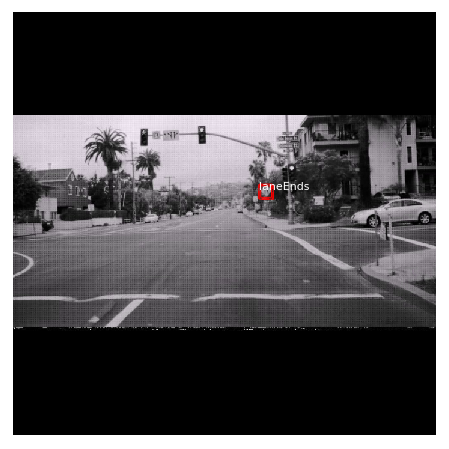

In [61]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
print(dataset_val.image_ids)
print(image_id)
original_image, image_meta,gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

mrcnn.visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            listOfLabels, figsize=(8, 8))

In [137]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    #print(bb1['x1'],"----",bb1['x2'])
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 500)
APs = []
counter = 0
for image_id in image_ids:
    print(counter)
    counter = counter + 1
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    repeat = 0
    while(r['rois'].size == 0):
        reults = model.detect([image], verbose=0)
        r = results[0]
        repeat = repeat + 1
        if(repeat > 5):
            break
    if(repeat > 5):
        continue
    print('HI')
    # Compute AP
    #print(gt_bbox)
    #print(r['rois'])
    gt_bbox_dict = {'x1':gt_bbox[0][1],'x2':gt_bbox[0][3],'y1':gt_bbox[0][0],'y2':gt_bbox[0][2]}
    results_bbox_dict = {'x1':r['rois'][0][1],'x2':r['rois'][0][3],'y1':r['rois'][0][0],'y2':r['rois'][0][2]}
    APs.append(get_iou(gt_bbox_dict,results_bbox_dict))
print(APs)
print("mAP: ", np.mean(APs))

0
1/1 [==============================] - 0s 201ms/step
HI
1
1/1 [==============================] - 0s 188ms/step
HI
2
1/1 [==============================] - 0s 204ms/step
HI
3
1/1 [==============================] - 0s 193ms/step
HI
4
1/1 [==============================] - 0s 192ms/step
HI
5
1/1 [==============================] - 0s 198ms/step
HI
6
1/1 [==============================] - 0s 186ms/step
7
1/1 [==============================] - 0s 185ms/step
HI
8
1/1 [==============================] - 0s 184ms/step
HI
9
1/1 [==============================] - 0s 192ms/step
HI
10
1/1 [==============================] - 0s 192ms/step
HI
11
1/1 [==============================] - 0s 195ms/step
HI
12
1/1 [==============================] - 0s 191ms/step
HI
13
1/1 [==============================] - 0s 192ms/step
HI
14
1/1 [==============================] - 0s 190ms/step
HI
15
1/1 [==============================] - 0s 184ms/step
16
1/1 [==============================] - 0s 207ms/step
HI
17
1/1 [=====

HI
97
1/1 [==============================] - 0s 191ms/step
HI
98
1/1 [==============================] - 0s 190ms/step
HI
99
1/1 [==============================] - 0s 188ms/step
HI
100
1/1 [==============================] - 0s 183ms/step
101
1/1 [==============================] - 0s 184ms/step
102
1/1 [==============================] - 0s 189ms/step
HI
103
1/1 [==============================] - 0s 194ms/step
HI
104
1/1 [==============================] - 0s 187ms/step
HI
105
1/1 [==============================] - 0s 187ms/step
HI
106
1/1 [==============================] - 0s 185ms/step
HI
107
1/1 [==============================] - 0s 191ms/step
HI
108
1/1 [==============================] - 0s 188ms/step
HI
109
1/1 [==============================] - 0s 194ms/step
HI
110
1/1 [==============================] - 0s 186ms/step
HI
111
1/1 [==============================] - 0s 187ms/step
112
1/1 [==============================] - 0s 187ms/step
113
1/1 [==============================] - 0s 190ms/

1/1 [==============================] - 0s 186ms/step
164
1/1 [==============================] - 0s 188ms/step
HI
165
1/1 [==============================] - 0s 187ms/step
HI
166
1/1 [==============================] - 0s 193ms/step
HI
167
1/1 [==============================] - 0s 190ms/step
HI
168
1/1 [==============================] - 0s 190ms/step
HI
169
1/1 [==============================] - 0s 190ms/step
HI
170
1/1 [==============================] - 0s 189ms/step
HI
171
1/1 [==============================] - 0s 190ms/step
HI
172
1/1 [==============================] - 0s 183ms/step
173
1/1 [==============================] - 0s 189ms/step
HI
174
1/1 [==============================] - 0s 186ms/step
175
1/1 [==============================] - 0s 190ms/step
HI
176
1/1 [==============================] - 0s 196ms/step
HI
177
1/1 [==============================] - 0s 192ms/step
HI
178
1/1 [==============================] - 0s 190ms/step
HI
179
1/1 [==============================] - 0s 190ms/s

HI
250
1/1 [==============================] - 0s 190ms/step
251
1/1 [==============================] - 0s 186ms/step
252
1/1 [==============================] - 0s 188ms/step
253
1/1 [==============================] - 0s 197ms/step
HI
254
1/1 [==============================] - 0s 200ms/step
HI
255
1/1 [==============================] - 0s 198ms/step
HI
256
1/1 [==============================] - 0s 194ms/step
HI
257
1/1 [==============================] - 0s 201ms/step
HI
258
1/1 [==============================] - 0s 200ms/step
HI
259
1/1 [==============================] - 0s 201ms/step
HI
260
1/1 [==============================] - 0s 200ms/step
HI
261
1/1 [==============================] - 0s 190ms/step
HI
262
1/1 [==============================] - 0s 194ms/step
HI
263
1/1 [==============================] - 0s 200ms/step
HI
264
1/1 [==============================] - 0s 196ms/step
HI
265
1/1 [==============================] - 0s 193ms/step
HI
266
1/1 [==============================] - 0s 

HI
329
1/1 [==============================] - 0s 194ms/step
HI
330
1/1 [==============================] - 0s 195ms/step
HI
331
1/1 [==============================] - 0s 190ms/step
HI
332
1/1 [==============================] - 0s 193ms/step
HI
333
1/1 [==============================] - 0s 197ms/step
HI
334
1/1 [==============================] - 0s 190ms/step
HI
335
1/1 [==============================] - 0s 187ms/step
HI
336
1/1 [==============================] - 0s 186ms/step
HI
337
1/1 [==============================] - 0s 188ms/step
338
1/1 [==============================] - 0s 197ms/step
HI
339
1/1 [==============================] - 0s 187ms/step
HI
340
1/1 [==============================] - 0s 189ms/step
HI
341
1/1 [==============================] - 0s 190ms/step
HI
342
1/1 [==============================] - 0s 180ms/step
343
1/1 [==============================] - 0s 181ms/step
344
1/1 [==============================] - 0s 184ms/step
HI
345
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 189ms/step
414
1/1 [==============================] - 0s 192ms/step
HI
415
1/1 [==============================] - 0s 188ms/step
HI
416
1/1 [==============================] - 0s 189ms/step
HI
417
1/1 [==============================] - 0s 186ms/step
HI
418
1/1 [==============================] - 0s 185ms/step
HI
419
1/1 [==============================] - 0s 188ms/step
HI
420
1/1 [==============================] - 0s 191ms/step
HI
421
1/1 [==============================] - 0s 185ms/step
422
1/1 [==============================] - 0s 191ms/step
HI
423
1/1 [==============================] - 0s 200ms/step
HI
424
1/1 [==============================] - 0s 193ms/step
HI
425
1/1 [==============================] - 0s 193ms/step
HI
426
1/1 [==============================] - 0s 198ms/step
HI
427
1/1 [==============================] - 0s 189ms/step
HI
428
1/1 [==============================] - 0s 191ms/step
HI
429
1/1 [==============================] - 0s 190m

Processing 1 images
image                    shape: (704, 704, 3)         min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 704, 704, 3)      min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 60)               min:    0.00000  max:  704.00000  int32
anchors                  shape: (1, 123783, 4)        min:   -0.12875  max:    1.03771  float32
1/1 [==============================] - 0s 200ms/step
mask =  (704, 704, 2)
['BG', 'stop', 'speedLimitUrdbl', 'speedLimit25', 'pedestrianCrossing', 'speedLimit35', 'turnLeft', 'slow', 'speedLimit15', 'speedLimit45', 'rightLaneMustTurn', 'signalAhead', 'keepRight', 'laneEnds', 'school', 'merge', 'addedLane', 'rampSpeedAdvisory40', 'rampSpeedAdvisory45', 'curveRight', 'speedLimit65', 'truckSpeedLimit55', 'thruMergeLeft', 'speedLimit30', 'stopAhead', 'yield', 'thruMergeRight', 'dip', 'schoolSpeedLimit25', 'thruTrafficMergeLeft', 'noRightTurn', 'rampSpeedAdvisory35', 'curveLeft', 'rampSpeedAdvisory

TypeError: only size-1 arrays can be converted to Python scalars

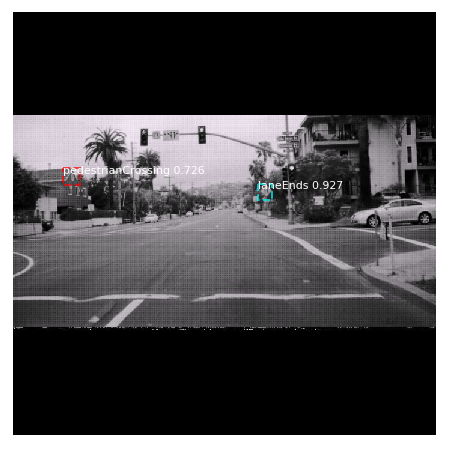

In [85]:
results = model.detect([original_image], verbose=1)

r = results[0]
print("mask = ",r['masks'].shape)
#visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset_val.class_names, r['scores'], ax=get_ax())
mrcnn.visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            listOfLabels, r['scores'], ax=get_ax())
backup = r['class_ids']
print(dataset_val.class_names)
print(r['class_ids'])
print(listOfLabels[int(r['class_ids'])])
print(r['scores'])

## Evaluation

In [75]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    print(my_compute_overlaps_masks(gt_mask,r['masks']))
    print(APs)
print("mAP: ", np.mean(APs))

1/1 [==============================] - 0s 193ms/step
None
[0.0]
mAP:  0.0


In [ ]:
entries = os.scandir(DATASET_PATH)
images = []
for entry in entries:
    if entry.name.endswith(".png"):
        images.append(entry.name)
        
for maskValuesRow in maskValues:
    if(maskValuesRow[1]=='speedLimit35'):
        print(maskValuesRow)

In [ ]:
import cv2
entries = os.scandir(DATASET_PATH)


for i in range(0,10):
    imagePath = DATASET_PATH +"\\" +(next(entries)).name
    original_image2 = cv2.imread(imagePath)
    print(imagePath)
    image2 = np.zeros_like(original_image2)
    image2[:,:,0] = original_image2[:,:,2]
    image2[:,:,1] = original_image2[:,:,1]
    image2[:,:,2] = original_image2[:,:,0]
    resized = cv2.resize(image2,(704,704))

    results = model.detect([resized], verbose=1)

    r = results[0]

    #visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    #                            dataset_val.class_names, r['scores'], ax=get_ax())

    mrcnn.visualize.display_instances(image2, r['rois'], r['masks'], r['class_ids'], 
                                listOfLabels, r['scores'], ax=get_ax(),show_mask=False,
                                      figsize=(8, 8))


In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta,gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

mrcnn.visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            listOfLabels, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]

mrcnn.visualize.display_instances(original_image, r['rois'],r['masks'], r['class_ids'], 
                            listOfLabels, r['scores'], ax=get_ax())
